For the tabular portion of the multimodal probabilistic model fusion, Gaussian Process is used, as it is particularly effective in capturing trends in time-series data, even with a small and irregular dataset. Gaussian Process is a stochastic learning method that learns the transition probability in a continuous time-scale by conditioning each discrete time-series data point with interpolated time intervals.

In [43]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import gpytorch
import matplotlib.pyplot as plt
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

For train-test split, it is done by unique patient IDs, as each row in the CSV is not a unique entry, but a series of rows for each patient ID is. Thus, the corresponding y (outcome) only is the FVC value in the last recorded week for each patient. 

Then, numerical features are normalized to ensure their equal weightage, followed by conversion to pyTorch tensors.



In [38]:
BASE_DIR = Path().resolve()
csv_path = BASE_DIR.parent / "data" / "train.csv"

df = pd.read_csv(csv_path).drop(columns = ["Percent"])

ids = df['Patient'].unique()
train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=3244)

train_df = df[df['Patient'].isin(train_ids)].reset_index(drop=True)
val_df   = df[df['Patient'].isin(val_ids)].reset_index(drop=True)

time_scaler = StandardScaler()
fvc_scaler = StandardScaler()
train_df["Weeks_scaled"] = time_scaler.fit_transform(train_df[["Weeks"]])
train_df["FVC_scaled"] = fvc_scaler.fit_transform(train_df[["FVC"]])
val_df["Weeks_scaled"] = time_scaler.transform(val_df[["Weeks"]])
val_df["FVC_scaled"] = fvc_scaler.transform(val_df[["FVC"]])
train_df = train_df.sort_values(["Patient", "Weeks"]).reset_index(drop=True)

#tidying validation dataframe (collapsing rows)
first_week = val_df.loc[val_df.groupby("Patient")["Weeks"].idxmin(), ["Patient", "Age", "Sex", "SmokingStatus", "Weeks_scaled", "FVC_scaled"]]
last_week  = val_df.loc[val_df.groupby("Patient")["Weeks"].idxmax(), ["Patient", "Weeks_scaled"]]
first_week = first_week.sort_values("Patient").reset_index(drop=True)
last_week  = last_week.sort_values("Patient").reset_index(drop=True)
dweek = last_week["Weeks_scaled"].values - first_week["Weeks_scaled"].values

val_df = val_df.loc[val_df.groupby("Patient")["Weeks_scaled"].idxmin(), ["Patient", "Age", "Sex", "SmokingStatus", "Weeks_scaled", "FVC_scaled"]]
val_df["Weeks_scaled"] = dweek
val_df = val_df.sort_values(["Patient"]).reset_index(drop=True)


Now that the preprocessing is complete, model is built with separate kernels for the time series, and each categorical feature.

In [40]:
X_time_train = torch.tensor(train_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_train = torch.tensor(train_df[["Age"]].values, dtype=torch.float32)

sex_map = {k:i for i,k in enumerate(train_df["Sex"].astype("category").cat.categories)}
smk_map = {k:i for i,k in enumerate(train_df["SmokingStatus"].astype("category").cat.categories)}
sex_train = torch.tensor(train_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_train = torch.tensor(train_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

y_train = torch.tensor(train_df["FVC_scaled"].values, dtype=torch.float32)

class MixedKernel(torch.nn.Module):
    has_lengthscale = False
    def __init__(self):
        super().__init__()
        self.time = ScaleKernel(MaternKernel(nu=1.5))
        self.age  = ScaleKernel(RBFKernel())

        self.sex  = IndexKernel(num_tasks=len(sex_map), rank=2)
        self.smk  = IndexKernel(num_tasks=len(smk_map), rank=2)

    def forward(self, x_time, x_age, x_sex, x_smk, diag=False, **params):
        Kt = self.time(x_time, x_time, diag=diag)
        Ka = self.age(x_age,  x_age,  diag=diag)

        Ks  = self.sex(x_sex,  x_sex)
        Km  = self.smk(x_smk,  x_smk)

        Kdemo = Ka + Ks + Km
        return Kt * Kdemo 
    

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, Xt, Xage, Xsex, Xsmk, y, likelihood):
        super().__init__(train_inputs=(Xt, Xage, Xsex, Xsmk), train_targets=y, likelihood=likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = MixedKernel()

    def forward(self, Xt, Xage, Xsex, Xsmk):
        mean = self.mean_module(torch.cat([Xt, Xage], dim=-1)) 
        covar = self.covar_module(Xt, Xage, Xsex, Xsmk)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

likelihood = GaussianLikelihood()
model = ExactGPModel(X_time_train, X_age_train, sex_train, smk_train, y_train, likelihood)

model.train(); likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for a, b in zip(model.train_inputs, (X_time_train, X_age_train, sex_train, smk_train)):
    print("equal:", torch.equal(a, b), "shape:", a.shape, b.shape, "dtype:", a.dtype, b.dtype, "device:", a.device, b.device)

for i in range(200):  
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()


model.eval(); likelihood.eval()

Xc_val  = torch.tensor(val_df[["Weeks_scaled","Age"]].values, dtype=torch.float32)
sex_val = torch.tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val = torch.tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_time_val = torch.tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
    X_age_val  = torch.tensor(val_df[["Age"]].values,          dtype=torch.float32)
    pred = likelihood(model(X_time_val, X_age_val, sex_val, smk_val))   
    y_mean = pred.mean.numpy()
    y_std  = pred.variance.sqrt().numpy()

equal: True shape: torch.Size([1234, 1]) torch.Size([1234, 1]) dtype: torch.float32 torch.float32 device: cpu cpu
equal: True shape: torch.Size([1234, 1]) torch.Size([1234, 1]) dtype: torch.float32 torch.float32 device: cpu cpu
equal: True shape: torch.Size([1234, 1]) torch.Size([1234, 1]) dtype: torch.int64 torch.int64 device: cpu cpu
equal: True shape: torch.Size([1234, 1]) torch.Size([1234, 1]) dtype: torch.int64 torch.int64 device: cpu cpu


c:\Users\rlaal\AppData\Local\Programs\Python\Python313\Lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:656.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


RMSE: 0.8943, R²: -0.0581


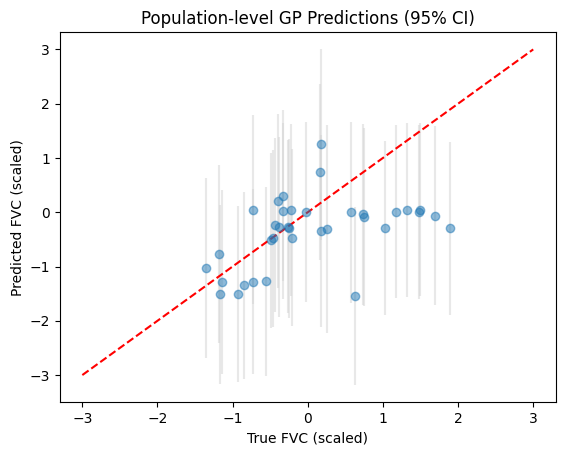

In [46]:
model.eval()
likelihood.eval()

X_time_val = torch.as_tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_val  = torch.as_tensor(val_df[["Age"]].values,          dtype=torch.float32)
sex_val    = torch.as_tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val    = torch.as_tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

y_true = torch.as_tensor(val_df["FVC_scaled"].values, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(X_time_val, X_age_val, sex_val, smk_val))

y_mean = pred.mean.cpu().numpy()
y_std  = pred.variance.sqrt().cpu().numpy()
y_true = y_true.cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_true, y_mean))
r2   = r2_score(y_true, y_mean)
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")


plt.figure()
plt.errorbar(y_true, y_mean, yerr=2*y_std, fmt='o', alpha=0.5, ecolor='lightgray')
plt.plot([-3,3],[-3,3],'r--')  # 1:1 line if still scaled
plt.xlabel("True FVC (scaled)")
plt.ylabel("Predicted FVC (scaled)")
plt.title("Population-level GP Predictions (95% CI)")
plt.show()
